In [2]:
from pathlib import Path
import duckdb, pandas as pd
import numpy as np
from scipy import stats

DB_PATH = Path("ds_week1.duckdb")  # same folder as this notebook
con = duckdb.connect(str(DB_PATH))
con.execute("SHOW TABLES").df()


,name
0,events
1,experiment_assignments
2,orders
3,users


In [3]:
# Set random seed for reproducibility
np.random.seed(7)

# Fetch users and assign them randomly to variants A or B
users = con.execute("SELECT user_id, signup_date FROM users").df()
users["variant"] = np.where(np.random.rand(len(users)) < 0.5, "A", "B")

# Store the assignments in a new table
con.execute("DROP TABLE IF EXISTS experiment_assignments")
con.register("assign_df", users[["user_id","variant"]])
con.execute("CREATE TABLE experiment_assignments AS SELECT * FROM assign_df")

In [4]:
# Verify the assignment counts
counts = con.execute("""
SELECT variant, COUNT(*) AS n
FROM experiment_assignments
GROUP BY 1
ORDER BY 1
""").df()
counts

,variant,n
0,A,1014
1,B,986


In [5]:
# Chi-squared test to check for equal distribution
obs = counts["n"].to_numpy()
exp = np.array([obs.sum()/2, obs.sum()/2])
chi2, p = stats.chisquare(obs, f_exp=exp)
chi2, p

(np.float64(0.392), np.float64(0.5312499859948483))

In [6]:
# Define the conversion metric: purchase within 7 days of signup
metric = con.execute("""
WITH first_purchase AS (
  SELECT user_id, MIN(order_time) AS first_purchase_time
  FROM orders
  GROUP BY 1
)
SELECT
  a.variant,
  u.user_id,
  CASE
    WHEN fp.first_purchase_time IS NOT NULL
     AND fp.first_purchase_time <= u.signup_date + INTERVAL 7 DAY
    THEN 1 ELSE 0
  END AS converted_7d
FROM users u
JOIN experiment_assignments a USING (user_id)
LEFT JOIN first_purchase fp USING (user_id);
""").df()

metric.head()

,variant,user_id,converted_7d
0,A,1,0
1,B,4,0
2,B,11,1
3,A,17,1
4,B,19,1


In [7]:
# Summarize conversion rates by variant
summary = metric.groupby("variant")["converted_7d"].agg(["count","mean"])
summary

,count,mean
variant,,
A,1014,0.144970
B,986,0.119675


In [8]:
# Z-test for difference in proportions
nA = summary.loc["A","count"]; pA = summary.loc["A","mean"]
nB = summary.loc["B","count"]; pB = summary.loc["B","mean"]

# pooled proportion
p_pool = (pA*nA + pB*nB) / (nA+nB)
se = np.sqrt(p_pool*(1-p_pool)*(1/nA + 1/nB))
z = (pB - pA) / se
p_value = 2*(1 - stats.norm.cdf(abs(z)))

lift = pB - pA
lift, z, p_value

(np.float64(-0.025294957811731092),
 np.float64(-1.6681446834872344),
 np.float64(0.09528700877175877))

In [9]:
# counts of conversions
xA = int(metric.loc[metric["variant"]=="A", "converted_7d"].sum())
xB = int(metric.loc[metric["variant"]=="B", "converted_7d"].sum())
nA = int(summary.loc["A","count"]); pA = float(summary.loc["A","mean"])
nB = int(summary.loc["B","count"]); pB = float(summary.loc["B","mean"])
lift = pB - pA

In [10]:
# Wilson score interval
def wilson_ci(x, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    p = x / n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = (z * np.sqrt((p*(1-p) + z**2/(4*n)) / n)) / denom
    return center - half, center + half

ciA = wilson_ci(xA, nA)
ciB = wilson_ci(xB, nB)

# Newcombe CI for difference in proportions
lift_ci_newcombe = (ciB[0] - ciA[1], ciB[1] - ciA[0])

ciA, ciB, lift, lift_ci_newcombe


((np.float64(0.12463943401635275), np.float64(0.16798134312618102)),
 (np.float64(0.1008769577268168), np.float64(0.14142605317917056)),
 -0.025294957811731092,
 (np.float64(-0.06710438539936421), np.float64(0.016786619162817817)))

In [11]:
# 95% confidence interval for the lift
se_unpooled = np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB)
ci_low = lift - 1.96*se_unpooled
ci_high = lift + 1.96*se_unpooled
(ci_low, ci_high)

(np.float64(-0.05496107948832689), np.float64(0.0043711638648647015))

In [12]:
# Power simulation function
def power_sim(n_per_group=1000, p_control=0.05, abs_lift=0.005, alpha=0.05, sims=2000, seed=0):
    rng = np.random.default_rng(seed)
    rejections = 0
    for _ in range(sims):
        A = rng.binomial(1, p_control, n_per_group)
        B = rng.binomial(1, p_control + abs_lift, n_per_group)
        pA = A.mean(); pB = B.mean()
        p_pool = (A.sum()+B.sum())/(2*n_per_group)
        se = np.sqrt(p_pool*(1-p_pool)*(2/n_per_group))
        z = (pB - pA)/se
        pval = 2*(1 - stats.norm.cdf(abs(z)))
        rejections += (pval < alpha)
    return rejections/sims

import matplotlib.pyplot as plt
import pandas as pd

sizes = [200, 500, 1000, 1500, 2000, 3000, 5000]
powers = [power_sim(n_per_group=n, p_control=0.05, abs_lift=0.005, sims=2000, seed=42) for n in sizes]

power_df = pd.DataFrame({"n_per_group": sizes, "power": powers})
power_df

,n_per_group,power
0,200,0.0490
1,500,0.0655
2,1000,0.0830
3,1500,0.0940
4,2000,0.1155
5,3000,0.1515
6,5000,0.1940


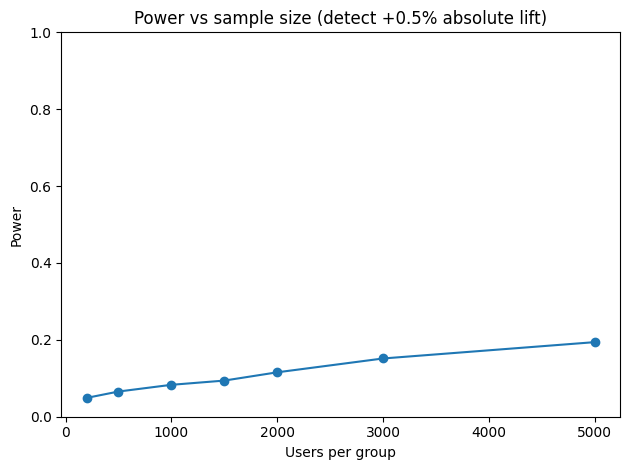

In [13]:
# Plot power vs sample size
plt.figure()
plt.plot(power_df["n_per_group"], power_df["power"], marker="o")
plt.title("Power vs sample size (detect +0.5% absolute lift)")
plt.xlabel("Users per group")
plt.ylabel("Power")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [14]:
# Peeking simulation to estimate false positive rate
def peek_false_positive_rate(
    max_n=5000,
    check_points=(500, 1000, 1500, 2000, 3000, 4000, 5000),
    p_true=0.05,
    alpha=0.05,
    sims=2000,
    seed=0
):
    rng = np.random.default_rng(seed)
    false_pos = 0

    for _ in range(sims):
        A = rng.binomial(1, p_true, max_n)
        B = rng.binomial(1, p_true, max_n)

        for n in check_points:
            pA = A[:n].mean()
            pB = B[:n].mean()
            p_pool = (A[:n].sum() + B[:n].sum()) / (2*n)
            se = np.sqrt(p_pool*(1-p_pool) * (2/n))
            if se == 0:
                continue
            z = (pB - pA) / se
            pval = 2*(1 - stats.norm.cdf(abs(z)))
            if pval < alpha:
                false_pos += 1
                break

    return false_pos / sims

rate_peeking = peek_false_positive_rate(sims=1500, seed=123)
rate_peeking

0.178

In [15]:
# Final analysis false positive rate simulation
def final_false_positive_rate(n=5000, p_true=0.05, alpha=0.05, sims=2000, seed=0):
    rng = np.random.default_rng(seed)
    fp = 0
    for _ in range(sims):
        A = rng.binomial(1, p_true, n)
        B = rng.binomial(1, p_true, n)
        pA = A.mean()
        pB = B.mean()
        p_pool = (A.sum()+B.sum())/(2*n)
        se = np.sqrt(p_pool*(1-p_pool) * (2/n))
        if se == 0:
            continue
        z = (pB - pA)/se
        pval = 2*(1 - stats.norm.cdf(abs(z)))
        fp += (pval < alpha)
    return fp/sims

rate_final = final_false_positive_rate(sims=1500, seed=123)
rate_final

np.float64(0.048)

In [16]:
# Summary of results
print("SRM chi2:", chi2, "p:", p)
print("pA:", pA, "pB:", pB, "lift:", lift)
print("z:", z, "p_value:", p_value)
print("Lift 95% CI (Newcombe):", lift_ci_newcombe)
print("Lift 95% CI (unpooled):", (ci_low, ci_high))
print("Power simulation (n=2000):", power_sim(n_per_group=2000, p_control=0.05, abs_lift=0.005))
print("Peeking false positive rate:", rate_peeking)
print("Final analysis false positive rate:", rate_final)

SRM chi2: 0.392 p: 0.5312499859948483
pA: 0.14497041420118342 pB: 0.11967545638945233 lift: -0.025294957811731092
z: -1.6681446834872344 p_value: 0.09528700877175877
Lift 95% CI (Newcombe): (np.float64(-0.06710438539936421), np.float64(0.016786619162817817))
Lift 95% CI (unpooled): (np.float64(-0.05496107948832689), np.float64(0.0043711638648647015))
Power simulation (n=2000): 0.109
Peeking false positive rate: 0.178
Final analysis false positive rate: 0.048
